# STATS 604: Gene expression in the Brain
## Team Members: Ben Agyare, Yumeng Wang, Jake Trauger, Yash Patel
We present herein the findings from our explorations on differential gene expression in the brain. In this report, we present some initial genes that could be of interest for further investigation. Such suggestions are further qualified with our corresponding level of confidence, largely based on replication across the statistical analyses we present. The report is, therefore, broken into the following sections:

- Data exploration
- Normalization
- T-test analysis
- GLM analysis
- Permutation test analysis
- Rank-sum analysis
- Conclusion

Each section is annotated with the corresponding code and figures in the sections below along with associated exposition.

In [29]:
import pyreadr
import sys
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import statsmodels
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from tqdm import tqdm
from multiprocess import Pool
from statsmodels.stats.multitest import fdrcorrection, multipletests

import pickle
import copy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import collections
import os
from scipy.ndimage.filters import gaussian_filter
import cv2
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False
blue, = sns.color_palette("muted", 1)

## Load and combine the data

In [2]:
result = pyreadr.read_r('./data/brain.rda')
#print(result.keys())
expression = result['expression']
genes = result['genes']
samples = result['samples']
print(expression.shape)
print(samples.shape)

# combine the expression and samples
data = pd.concat([expression, samples], axis=1)

(84, 12600)
(84, 5)


## Exploratory analysis

We first do some exploratory data analysis. We compare the data distribution of female and male, and AC and DLPF from three different labs.

### Female and male

From the following two plots, we see that the distributions of female and male in each lab are similar. However, there exists a substantial difference among the three different labs, where the data in Michigan has the smallest mean value while the data in Irvine has the largest mean value.

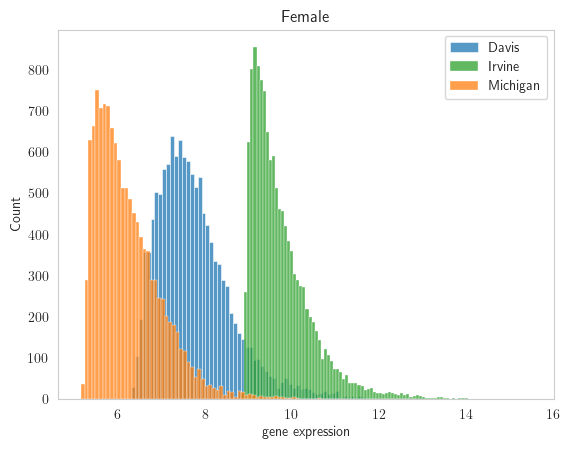

In [3]:
data_sex = data.groupby(['sex', 'lab']).median()
sns.histplot(data_sex.iloc[0,], label = 'Davis', color ='tab:blue')
sns.histplot(data_sex.iloc[1,], label = 'Irvine', color = 'tab:green')
sns.histplot(data_sex.iloc[2,], label = 'Michigan', color = 'tab:orange')

plt.title('Female')
plt.xlabel('gene expression')
plt.legend(labels=['Davis', 'Irvine', 'Michigan']) 

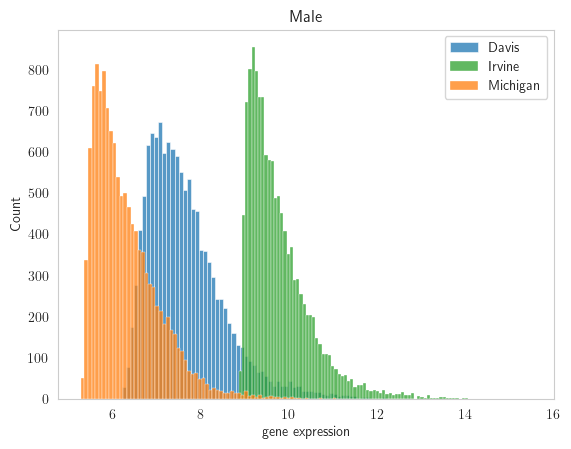

In [4]:
sns.histplot(data_sex.iloc[3,], label = 'Davis', color ='tab:blue')
sns.histplot(data_sex.iloc[4,], label = 'Irvine', color = 'tab:green')
sns.histplot(data_sex.iloc[5,], label = 'Michigan', color = 'tab:orange')

plt.title('Male')
plt.xlabel('gene expression')
plt.legend(labels=['Davis', 'Irvine', 'Michigan']) 

### AC and DLPF

From the following two plots, we also see that the distributions of AC and DLPF in each lab are similar and there exists a substantial difference among the three different labs.

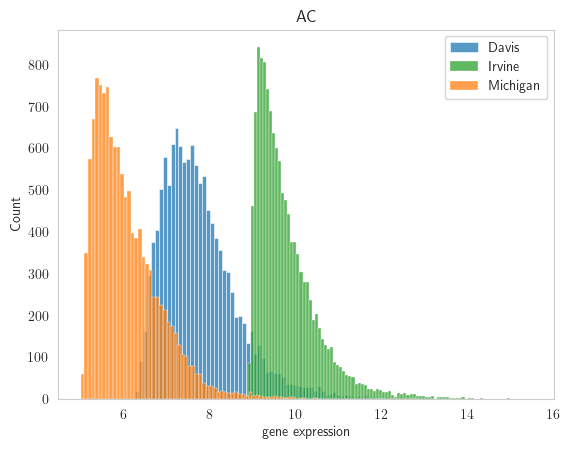

In [5]:
data_region = data.groupby(['region', 'lab']).median()
sns.histplot(data_region.iloc[0,], label = 'Davis', color ='tab:blue')
sns.histplot(data_region.iloc[1,], label = 'Irvine', color = 'tab:green')
sns.histplot(data_region.iloc[2,], label = 'Michigan', color = 'tab:orange')

plt.title('AC')
plt.xlabel('gene expression')
plt.legend(labels=['Davis', 'Irvine', 'Michigan']) 

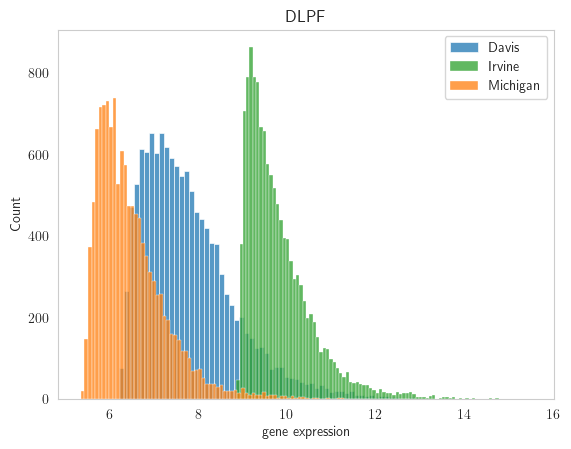

In [6]:
data_region = data.groupby(['region', 'lab']).median()
sns.histplot(data_region.iloc[3,], label = 'Davis', color ='tab:blue')
sns.histplot(data_region.iloc[4,], label = 'Irvine', color = 'tab:green')
sns.histplot(data_region.iloc[5,], label = 'Michigan', color = 'tab:orange')

plt.title('DLPF')
plt.xlabel('gene expression')
plt.legend(labels=['Davis', 'Irvine', 'Michigan']) 

## Exploratory Analysis Takeaways
From these initial findings, we find that it is necessary to perform normalization of the data to allow for comparisons between labs. Doing normalization, however, can take a number of forms, which is the primary difference in the statistical analyses presented next. In the first, we perform explicit normalization using a combination of spike-in normalization and latent "gene expression" extraction followed by t-tests. For GLMs, the nuisance parameters are explicitly added as variables to the model, thereby allowing us to look at the isolated effect of the genes. In the last, we similarly perform "implicit normalization" by just analyzing the ranks of the data.

## Normalization
We need to do some normalization with the bacterial spike-ins. According to the following two sources:
- https://support.bioconductor.org/p/49150/
- https://bioinformatics.mdanderson.org/MicroarrayCourse/Lectures/ma07b.pdf
two common normalization techniques are spike-in normalizatio and quantile normalization. The former doesn't really involve much assumption beyond the experimental consistency of spike-in amounts. Given that this itself could vary across labs, we should verify this behavior prior to applying spike-in normalization. Quantile normalization assumes that most genes are *not* differentially expressed (that only a handful are). 

### Spike-In Normalization
Let's start by looking at the plausibility of this spike-in normalization technique.

In [7]:
with open("data/brain.pkl", "rb") as f:
    dataset = pickle.load(f)

In [8]:
expression = dataset["expression"]
genes = dataset["genes"]
samples = dataset["samples"]

In [9]:
nan_genes = genes[genes["chrom"].isna()].index.values # genes not associated with chromosomes
control_genes = [gene for gene in nan_genes if gene.startswith("AFFX")]
human_genes = [gene for gene in genes.index.values if gene not in control_genes]
print(control_genes)

['AFFX-BioB-3_at', 'AFFX-BioB-3_st', 'AFFX-BioB-5_at', 'AFFX-BioB-5_st', 'AFFX-BioB-M_at', 'AFFX-BioB-M_st', 'AFFX-BioC-3_at', 'AFFX-BioC-3_st', 'AFFX-BioC-5_at', 'AFFX-BioC-5_st', 'AFFX-BioDn-3_st', 'AFFX-BioDn-5_at', 'AFFX-BioDn-5_st', 'AFFX-CreX-3_at', 'AFFX-CreX-3_st', 'AFFX-CreX-5_at', 'AFFX-CreX-5_st', 'AFFX-DapX-3_at', 'AFFX-DapX-5_at', 'AFFX-DapX-M_at', 'AFFX-HUMRGE/M10098_3_at', 'AFFX-HUMRGE/M10098_5_at', 'AFFX-HUMRGE/M10098_M_at', 'AFFX-LysX-3_at', 'AFFX-LysX-5_at', 'AFFX-LysX-M_at', 'AFFX-M27830_3_at', 'AFFX-M27830_5_at', 'AFFX-M27830_M_at', 'AFFX-MurFAS_at', 'AFFX-MurIL10_at', 'AFFX-MurIL2_at', 'AFFX-MurIL4_at', 'AFFX-PheX-3_at', 'AFFX-PheX-5_at', 'AFFX-PheX-M_at', 'AFFX-ThrX-3_at', 'AFFX-ThrX-5_at', 'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at', 'AFFX-TrpnX-5_at', 'AFFX-TrpnX-M_at', 'AFFX-YEL002c/WBP1_at', 'AFFX-YEL018w/_at', 'AFFX-YEL021w/URA3_at', 'AFFX-YEL024w/RIP1_at', 'AFFX-hum_alu_at']


In [10]:
lab_names = ["Davis", "Michigan", "Irvine"]
lab_to_data = {}
for lab in lab_names:
    lab_patients = samples[samples["lab"] == lab].index
    lab_to_data[lab] = expression.loc[lab_patients]

Given the consistency of the spike in *per lab*, however, it seems plausible to actually go ahead with this spike-in normalization. To do so, we count gene expressed in a "normalized space" based on the total amount of control genes expressed:

$$ \widehat{g} = \frac{g}{\frac{1}{|\{c_g\}|} \sum {c_g}} $$

Where $g$ is some gene of interest and $c_g$ the set of controls.

In [51]:
lab_to_normalized_data = {}
for lab in lab_names:
    row_means = lab_to_data[lab][control_genes].mean(axis=1)
    normalized = lab_to_data[lab].div(row_means, axis=0)
    lab_to_normalized_data[lab] = normalized

This plot suggests that there are no systematic differences between the two version, which suggests that combining the samples is reasonable.

## Investigating Combining Versions
We can perform this analysis in two ways: take the labs separately and treat them as separate experiments for the analysis. Or combine them and do the analysis on this combined dataset. The rationale behind the latter is to view the measurements of each labs as noisy representations of the "true" gene expressions. Before doing so, one thing that differed between otherwise seeming "replicates" of samples between labs was the version of the chip that was used. We first wish to investigate if there is any systematic difference between the versions by visualizing paired samples (i.e. samples that are otherwise replicates) after projecting them to a lower dimensional space via PCA.

In [12]:
michigan = lab_to_normalized_data["Michigan"]
davis = lab_to_normalized_data["Davis"]
irvine = lab_to_normalized_data["Irvine"]

In [13]:
v1_samples = samples[samples["chip.version"] == "v1"]
v2_samples = samples[samples["chip.version"] == "v2"]

In [14]:
# WARNING: very inscrutable code ahead: this is to basically "tie together" the patients into tuples (which is annoyingly complicated
# cause some of the data were dropped from the Irvine lab)

patient_ids = [f"patient_{str(patient_idx).rjust(2, '0')}" for patient_idx in range(1, 11)]

lab_tuple_labels = set(["Davis", "Irvine", "Michigan"])
patient_id_tuples = {}

for patient_id in patient_ids:
    patient_samples = samples[samples["patient"] == patient_id]
    
    cur_tuple_labels = copy.deepcopy(lab_tuple_labels)
    cur_patient_tuple = []
    
    patient_tuples = []
    for _, patient_sample in patient_samples.iterrows():  
        if patient_sample["lab"] not in cur_tuple_labels:
            patient_tuples.append(cur_patient_tuple)
            cur_tuple_labels = copy.deepcopy(lab_tuple_labels)
            cur_patient_tuple = []
        
        cur_tuple_labels.remove(patient_sample["lab"])
        cur_patient_tuple.append(patient_sample)
    if len(cur_patient_tuple) > 0:
        patient_tuples.append(cur_patient_tuple)
    patient_id_tuples[patient_id] = patient_tuples

In [15]:
v1_data, v2_data = [], []
for patient_id in patient_id_tuples:
    for paired_tuples in patient_id_tuples[patient_id]:
        v1_subset, v2_subset = [], []
        for sample in paired_tuples:
            if sample["chip.version"] == "v1":
                v1_subset.append(sample)
            else:
                v2_subset.append(sample)
        v1_data.append(v1_subset)
        v2_data.append(v2_subset)

In [16]:
from sklearn.decomposition import PCA

In [17]:
lab_to_reduced_data = {}
for lab in lab_to_normalized_data:
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(lab_to_normalized_data[lab][human_genes].values)
    lab_to_reduced_data[lab] = pd.DataFrame(reduced_data, columns = ['pc1','pc2'], index = lab_to_normalized_data[lab].index)

Text(0.5, 1.0, '$\\mathrm{PCs \\ For \\ V1 \\ vs \\ V2 \\ Samples}$')

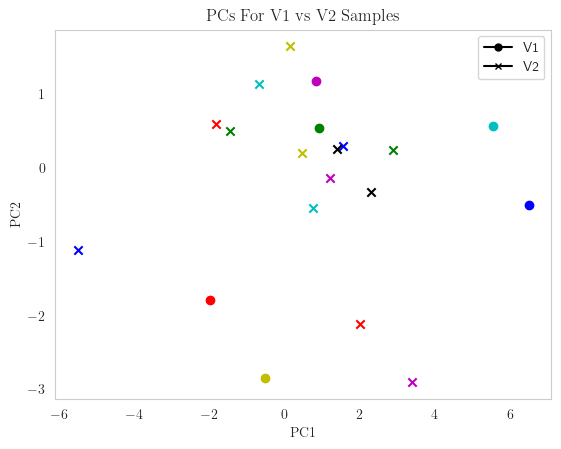

In [18]:
colors = ["b","g","r","c","m","y","k","w"]
for i, (v1_samples, v2_samples) in enumerate(zip(v1_data[8:16], v2_data[8:16])):    
    for v1_sample in v1_samples:
        x, y = lab_to_reduced_data[v1_sample["lab"]].loc[v1_sample.name]
        plt.scatter(x, y, color=colors[i], marker="o")
    for v2_sample in v2_samples:
        x, y = lab_to_reduced_data[v2_sample["lab"]].loc[v2_sample.name]
        plt.scatter(x, y, color=colors[i], marker="x")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='k', markersize=5, label='V1'),
    Line2D([0], [0], marker='x', color='k', markersize=5, label='V2'),
]
plt.legend(handles=legend_elements)

plt.xlabel(r"$\mathrm{PC1}$")
plt.ylabel(r"$\mathrm{PC2}$")
plt.title(r"$\mathrm{PCs \ For \ V1 \ vs \ V2 \ Samples}$")

## T-test Analysis
We currently have normalized data from which we can analyze the difference in *probes* between males and females (and similarly for the brain regions), but recall that the true object of interest for comparison is the *gene expression*. We can currently only do this analysis in an obfuscated light, where the probe sets highlight differences that we then map back to the corresponding genes. It, however, makes sense to eliminate chip-level effects to uncover the latent "gene expression" and only then compare them across the subjects of interest.

Specifically, recalling that each gene has several corresponding probes, for an array $i$, probe $j$, and gene $k$, we can model the measured expression as being:

$$ Y_{ijk} = \mu_{ik} + \alpha_{jk} + \epsilon_{ijk} $$

Where:

- $\mu_{ik}$: "True" gene expression
- $\alpha_{jk}$: Probe affinity effect
- $\epsilon_{ijk}$: Noise

We wish then to estimate $\mu_{ik}$. Let's fix a gene $k$ for this discussion, from which we now wish to estimate $\mu_i$. We estimate this using Tukey’s Median Polish algorithm, which breaks the above relation into:

$$ Y_{ij} = \mu + \delta_i + \alpha_j + \epsilon_{ij} $$

Where:

- $\mu + \delta_i$: "True" gene expression
- $\alpha_{j}$: Probe affinity effect
- $\epsilon_{ij}$: Noise

So, after running a Median Polish, we take our estimate to be: $\widehat{\mu_i} = \widehat{\mu} + \widehat{\delta_i}$

In [53]:
lab_names = ["Davis", "Michigan", "Irvine"]
lab_to_normalized_data = {}
for lab in lab_names:
    lab_patients = samples[samples["lab"] == lab].index
    raw_lab_expression = expression.loc[lab_patients]
    control_means = raw_lab_expression[control_genes].mean(axis=1)
    lab_to_normalized_data[lab] = raw_lab_expression.div(control_means, axis=0)[human_genes]

In [54]:
sort_dict = lambda unsorted_dict : {k: v for k, v in sorted(unsorted_dict.items(), key=lambda item: -item[1])}

In [55]:
def pretty_print(d):
    for k in d:
        print(f"{k} -> {d[k]}")

In [56]:
def print_results(all_significant_probes):
    significant_chromosomes = {}
    significant_genes = {}
    for probe in all_significant_probes:
        chrom = genes.loc[probe]["chrom"]
        gene = genes.loc[probe]["sym"]
        
        if chrom not in significant_chromosomes:
            significant_chromosomes[chrom] = 0
        if gene not in significant_genes:
            significant_genes[gene] = 0
        
        significant_chromosomes[chrom] += 1
        significant_genes[gene] += all_significant_probes[probe]
    pretty_print(sort_dict(significant_genes))


In [57]:
def median_polish(tbl, max_iterations=10, method='median'):
    grand_effect = 0
    median_row_effects = 0
    median_col_effects = 0
    row_effects = np.zeros(shape=tbl.shape[0])
    col_effects = np.zeros(shape=tbl.shape[1])

    for i in range(max_iterations):
        if method == 'median':
            row_medians = np.median(tbl  ,1) 
            row_effects += row_medians
            median_row_effects = np.median(row_effects)
        elif method == 'average':
            row_medians = np.average(tbl  ,1) 
            row_effects += row_medians
            median_row_effects = np.average(row_effects)
        grand_effect += median_row_effects
        row_effects -= median_row_effects
        tbl -= row_medians[:,np.newaxis] 

        if method == 'median':
            col_medians = np.median(tbl,0) 
            col_effects += col_medians
            median_col_effects = np.median(col_effects)
        elif method == 'average':
            col_medians = np.average(tbl,0) 
            col_effects += col_medians
            median_col_effects = np.average(col_effects)

        tbl -= col_medians 
        grand_effect += median_col_effects

    return grand_effect, col_effects, row_effects , tbl

In [58]:
gene_syms = list(genes["sym"].values)
gene_to_probes = {}
for gene_sym in gene_syms:
    if gene_sym != gene_sym:
        continue # skip nan case
    gene_to_probes[gene_sym] = genes[genes["sym"] == gene_sym].index.values

In [59]:
lab_to_gene_data = {}

for lab_name in lab_to_normalized_data:
    lab = lab_to_normalized_data[lab_name]
    gene_expressions = {}
    for gene in gene_to_probes:
        probe_cols = lab[gene_to_probes[gene]].values
        grand_effect, col_effects, row_effects, tbl = median_polish(probe_cols)
        gene_est = row_effects + grand_effect
        gene_expressions[gene] = gene_est

    lab_genes = pd.DataFrame.from_dict(gene_expressions)
    lab_genes = lab_genes.set_index(lab.index)
    lab_to_gene_data[lab_name] = lab_genes

### T-test [Sex]
We investigate first the differential expression of sex from the gene data extracted above. Such gene expressions are analyzed *per lab*, which we then analyze for replication. That is, from the individual analyses, we see which genes are found repeatedly across the different labs, which gives us greater confidence in such findings. This analysis is performed with a simply independent t-test using a Benjamini-Hochberg procedure to control the FDR to 0.11. Note that we are using a relatively high FDR value because we wish to find all plausible candidates for further investigation. 

To provide further validation, we additionally investigate these results if the data are further split by the brain region. That is, we then compare ACC males vs. ACC females, DLPF males vs. DLPF females, and so on. Given the reduced sample size in doing this splitting, the power of this procedure is reduced, but it serves as a means of finding a more conservative set of genes for further exploration.

In [65]:
def perform_t_analysis(combined_analysis):
    for region_idx, brain_region in enumerate(["A.C. cortex", "cerebellum", "D.L.P.F. cortex"]):
        all_significant_genes = {}
        for lab_name in lab_to_gene_data:
            gene_data = lab_to_gene_data[lab_name]
            lab_patients = samples[samples["lab"] == lab_name]

            male_patients = lab_patients[lab_patients["sex"] == "male"]
            female_patients = lab_patients[lab_patients["sex"] == "female"]

            if combined_analysis:
                male_patients = male_patients.index
                female_patients = female_patients.index
            else:
                male_patients = male_patients[male_patients["region"] == brain_region].index
                female_patients = female_patients[female_patients["region"] == brain_region].index

            male_data = gene_data.loc[male_patients].values
            female_data = gene_data.loc[female_patients].values

            pvalues = scipy.stats.ttest_ind(male_data, female_data).pvalue
            fdr_pvalues = statsmodels.stats.multitest.multipletests(pvalues, alpha=0.11, method='fdr_bh')
            significant = np.where(fdr_pvalues[0])
            ref_columns = gene_data.columns.values
            significant_genes = ref_columns[significant[0]]

            for significant_gene in significant_genes:
                if significant_gene not in all_significant_genes:
                    all_significant_genes[significant_gene] = 0
                all_significant_genes[significant_gene] += 1    
        
        all_significant_chroms = {}
        for significant_gene in all_significant_genes:
            chrom = genes[genes["sym"] == significant_gene]["chrom"].values[0]
            if chrom not in all_significant_chroms:
                all_significant_chroms[chrom] = []
            all_significant_chroms[chrom].append(significant_gene)

        if not combined_analysis or (combined_analysis and region_idx == 2):
            pretty_print(all_significant_chroms)
            pretty_print(sort_dict(all_significant_genes))
            print("=============================================")

In [66]:
perform_t_analysis(combined_analysis=True)

Y -> ['USP9Y', 'KDM5D', 'DDX3Y', 'RPS4Y1', 'UTY']
X -> ['XIST']
KDM5D -> 3
DDX3Y -> 3
RPS4Y1 -> 3
USP9Y -> 2
UTY -> 1
XIST -> 1


In [67]:
perform_t_analysis(combined_analysis=False)

Y -> ['RPS4Y1']
RPS4Y1 -> 1
Y -> ['RPS4Y1', 'DDX3Y']
RPS4Y1 -> 2
DDX3Y -> 1
Y -> ['RPS4Y1', 'DDX3Y']
RPS4Y1 -> 1
DDX3Y -> 1


### T-test [Brain Region]
We repeat the procedure above, now instead using a dependent t-test, since each ACC and DLPF sample pair comes from the same patient.

In [31]:
all_significant_genes = {}
for lab_name in lab_to_gene_data:
    gene_data = lab_to_gene_data[lab_name]
    lab_patients = samples[samples["lab"] == lab_name]

    acc_patients = lab_patients[lab_patients["region"] == "A.C. cortex"].index
    dlpf_patients = lab_patients[lab_patients["region"] == "D.L.P.F. cortex"].index

    acc_data = gene_data.loc[acc_patients].values
    dlpf_data = gene_data.loc[dlpf_patients].values

    pvalues = scipy.stats.ttest_ind(acc_data, dlpf_data).pvalue
    fdr_pvalues = statsmodels.stats.multitest.multipletests(pvalues, alpha=0.00001, method='fdr_bh')
    significant = np.where(fdr_pvalues[0])
    ref_columns = gene_data.columns.values
    significant_genes = ref_columns[significant[0]]

    for significant_gene in significant_genes:
        if significant_gene not in all_significant_genes:
            all_significant_genes[significant_gene] = 0
        all_significant_genes[significant_gene] += 1    

pretty_print(sort_dict(all_significant_genes))

BTN3A1 -> 1
AURKB -> 1
LDB1 -> 1
GTF3C1 -> 1
GIPC1 -> 1
SLC9A3R2 -> 1


The brain region findings seem to be highly spurious given the tremendous differential expression found between the ACC in the DLPF in the Michigan data but complete lack thereof in other labs' datasets. This is further compounded by the fact we had to reduce the FDR control to 0.00001 to restrict the total findings to a reasonable number. Such a disparity leads us to believe these results are spurious and should *not* be trusted. We instead opt to suggest the results found in the latter two analyses due to their replication.

## T-test Takeaways
Therefore, from the t-test analysis, we find the following genes, along with the corresponding replications. Italicized results also significant in combined lab analysis:

**Sex**

| Gene | Replications |
| --- | --- |
| *KDM5D* | 3 |
| *DDX3Y* | 3 |
| *RPS4Y1* | 3 |
| USP9Y | 2 |
| XIST | 2 |
| UTY | 1 |

**Region**

| Gene | Replications |
| --- | --- |
| BTN3A1  | 1  |
| AURKB  | 1  |
| LDB1  | 1  |
| GTF3C1 | 1 |
| GIPC1 | 1 |
| SLC9A3R2 | 1 |

## GLM Analysis

Another test we ran was done by using generalized linear models (GLMs). When doing prelimary research on the topic of differential expressions we found an R package called DESeq2. This package has over 27000 citations and it uses GLMs on the raw count data, along with more technical processes to get differentially expressed genes.  Therefore, since it seems that GLMs are a well preceded method in the bioinformatics community we decided to try our own GLM model to test the research questions.

As for the specifics, we ran a GLM on the original dataset with a gaussian family and canonical link. For the formula we use gene_expression ~ \[variable we are looking at\] + lab + chip.version + constant. The lab and chip version were added to control for any confounding they might have since we are still using the original dataset. Therefore, this method can also be used as a sanity check for making sure our normalization works as desired. If the GLM model and our model that uses our normalized data output similar genes, then we have more confidence in both our results and techniques.

### GLM [Sex]
For the males and females split, we ran a GLM on each gene and found the p-value for the sex variable. We then ran the Bonferroni family-wise error rate correction with $\alpha = .05$ and got 2 genes that are significant: DDX3Y and RPS4Y1. We choose to use a Bonferroni correction due to its conservative nature. Since GLMs are well precedented and the Bonferroni procedure is a very conserative correction, we can be very confident that the findings we get for our GLMs are worth looking into.

In [32]:
rda = pyreadr.read_r('data/brain.rda')
expression = rda["expression"]
genes = rda["genes"]
samples = rda["samples"]

norm_data = pd.read_csv("data/normalized_genes.csv")
no_bact_cols = expression.loc[:,[not x for x in genes["chrom"].isna().to_numpy()]].columns

In [33]:
glm_no_normal = expression.copy()
glm_no_normal["sex"] = samples["sex"]
glm_no_normal["region"] = samples["region"]
glm_no_normal["lab"] = samples["lab"]
glm_no_normal["chip.version"] = samples["chip.version"]
glm_no_normal["patient"] = samples["patient"]
formula = "38355_at~sex+region+lab+chip.version"
columns = ["sex","lab","chip.version"]
dummies = pd.get_dummies(data=glm_no_normal[columns], columns=columns, drop_first=True)
dummies = sm.add_constant(dummies)
dummies
pvals_m_f = []
#a = smf.glm(formula=formula, data=glm_no_normal, family=sm.families.Gamma(sm.families.links.log())).fit()
for i in no_bact_cols:
    a = sm.GLM(endog=glm_no_normal[i], exog=dummies, family=sm.families.Gaussian()).fit()#sm.families.NegativeBinomial(sm.families.links.log())).fit()
    pvals_m_f.append((a.pvalues[1],i))

In [34]:
for x in np.array(pvals_m_f)[multipletests([x[0] for x in pvals_m_f], alpha=.05, method="bonferroni")[0]]:
    print(genes.loc[x[1]]["sym"])

DDX3Y
RPS4Y1


### GLM [Brain Region]
For the region split, we ran a GLM on each gene and found the p-value for the region variable. We then ran the Bonferroni family-wise error rate correction with $\alpha = .05$ and got 4 genes that are significant: CABP1, CARTPT, SCN1B, COX7A1.

In [35]:
glm_region = expression.copy()
glm_region["sex"] = samples["sex"]
glm_region["region"] = samples["region"]
glm_region["lab"] = samples["lab"]
glm_region["chip.version"] = samples["chip.version"]
glm_region["patient"] = samples["patient"]
glm_region=glm_region.loc[[x in ["A.C. cortex", "D.L.P.F. cortex"] for x in glm_region["region"]]]
columns = ["region","lab","chip.version"]
dummies = pd.get_dummies(data=glm_region[columns], columns=columns, drop_first=True)
dummies = sm.add_constant(dummies)
dummies = dummies.drop(["region_cerebellum"], axis=1)
pvals_region = []
#a = smf.glm(formula=formula, data=glm_no_normal, family=sm.families.Gamma(sm.families.links.log())).fit()
for i in no_bact_cols:
    a = sm.GLM(endog=glm_region[i], exog=dummies, family=sm.families.Gaussian()).fit()#sm.families.NegativeBinomial(sm.families.links.log())).fit()
    pvals_region.append((a.pvalues[1],i))

In [36]:
for x in np.array(pvals_region)[multipletests([x[0] for x in pvals_region], alpha=.05, method="bonferroni")[0]]:
    print(genes.loc[x[1]]["sym"])

CABP1
CARTPT
SCN1B
COX7A1


## Permutation Test Analysis
We also ran a Monte-Carlo permutation test on the difference of means on our research questions using the normalized data. Given a gene, if under the null hypothesis males and females (or A.C.C. vs D.L.P.F.C.) have no differences, then if we aggregate the male and female data points and go through all possible permutations of male/female (A.C.C./D.L.P.F.C.) assignment, then we can see how unlikely our found difference in means was. However, since we have many genes and many samples for each gene, going through all possible permutations is computationally expensive. Thus, we only run 1000 random permutations and get our p-value from these permutations. It is known that the standard deviation of this is $\sqrt{\frac{\hat{p}(1-\hat{p})}{1000}} \leq \sqrt{\frac{.5\cdot.5}{1000}} \approx .0158$, which we deemed acceptable due to the leniency we have been given to find differentably expressed genes.

In [37]:
def perm(data1, data2, runs, test_stat):
    '''Does a Monte Carlo permutation test'''
    count = 0
    for i in range(runs):
        total_data = np.concatenate((data1, data2))
        perm_data1 = np.random.choice(total_data, len(data1))
        perm_data2 = np.setdiff1d(total_data, perm_data1)
        if test_stat(perm_data1, perm_data2) > test_stat(data1, data2):
            count += 1
    p_hat = count/runs
    return (p_hat, np.sqrt((p_hat*(1-p_hat))/runs)) #p_hat and std_dev returned

def perm_multi(a):
    '''Does a Monte Carlo permutation test, but written so that we can use multiprocessing'''
    data1, data2, runs, test_stat, col = a
    count = 0
    for i in range(runs):
        total_data = np.concatenate((data1, data2))
        perm_data1 = np.random.choice(total_data, len(data1))
        perm_data2 = np.setdiff1d(total_data, perm_data1)
        if test_stat(perm_data1, perm_data2) > test_stat(data1, data2):
            count += 1
    p_hat = count/runs
    return (p_hat, np.sqrt((p_hat*(1-p_hat))/runs), col) #p_hat, std_dev, and column name returned

### Permutation Test [Sex]
When running our Monte-Carlo permutation tests for male vs. female, using the Benjamini-Hochberg false discovery rate correction with $\alpha = .1$, we got the following 5 differentiably expressed genes: UTY, USP9Y, KDM5D, DDX3Y, RPS4Y1.

In [38]:
males = norm_data.loc[norm_data["rownames"].isin(((samples["sex"]=="male").index[(samples["sex"]=="male")]))]
females = norm_data.loc[norm_data["rownames"].isin(((samples["sex"]=="female").index[(samples["sex"]=="female")]))]
columns = norm_data.columns.to_numpy()[1:]

In [39]:
max_pool = 8
arrs = [(males[col], females[col],1000, lambda x,y: abs(np.mean(x) - np.mean(y)), col) for col in columns]
with Pool(max_pool) as p:
    sex_outputs = list(tqdm(p.imap(perm_multi,arrs),total=len(arrs)))

100%|██████████| 8783/8783 [03:05<00:00, 47.37it/s]


In [40]:
sex_outputs.sort(key=lambda x: x[0])
for x in np.array(sex_outputs)[multipletests([x[0] for x in sex_outputs], alpha=.1, method="fdr_bh")[0]]:
    print(x[2])

UTY
USP9Y
KDM5D
DDX3Y
RPS4Y1


### Permutation Test [Brain Region]
When running our Monte-Carlo permutation tests for A.C. cortex vs. D.L.P.F. cortex, using the Benjamini-Hochberg false discovery rate correction with $\alpha = .1$, we got the following 10 differentiably expressed genes: ZNF609, DAPK3, CARTPT, AP1S1, ZYX, NDUFS8, CAMTA1, CCDC106, SLC9A3R2, RHBDD3. While these only share 1 common gene with the GLM model, we will note that the others declared significant in the GLM model were still among the genes with the smallest $\hat{p}$ with the largest of them having a $\hat{p}$ of $.015$.

In [41]:
acc = norm_data.loc[norm_data["rownames"].isin(((samples["region"]=="A.C. cortex").index[(samples["region"]=="A.C. cortex")]))]
dlpfc = norm_data.loc[norm_data["rownames"].isin(((samples["region"]=="D.L.P.F. cortex").index[(samples["region"]=="D.L.P.F. cortex")]))]

In [42]:
max_pool = 8
arrs = [(acc[col], dlpfc[col],1000, lambda x,y: abs(np.mean(x) - np.mean(y)), col) for col in columns]
with Pool(max_pool) as p:
    region_outputs = list(tqdm(p.imap(perm_multi,arrs),total=len(arrs)))

100%|██████████| 8783/8783 [03:12<00:00, 45.67it/s]


In [43]:
region_outputs.sort(key=lambda x: x[0])
for x in np.array(region_outputs)[multipletests([x[0] for x in region_outputs], alpha=.1, method="fdr_bh")[0]]:
    print(x[2])

FGF9
CAMK1
SLC1A7
RDH5
RHBDL1
AQP8
CARTPT
PARN
MCAT
ZYX
NDUFS8
NCDN
SNCB
SLC9A3R2


## Wilcoxon Rank Sum Test

We consider a nonparametric statistical test method, the Wilcoxon rank sum test, which compares the population median of two samples. The null hypothesis is that the population distributions of female and male are the same. Next, we run the test in three different labs separately, and also run the test in combined data.

### Rank-Sum Test [Sex]
We start with running the analysis separately for the labs:

In [44]:
# Genes that stand out in davis
data_female_Davis = data[(data['sex'] == 'female') & (data['lab'] == 'Davis')]
data_male_Davis = data[(data['sex'] == 'male') & (data['lab'] == 'Davis')]
p_gender_Davis_all = []
p_gender_Davis_sign = []
idx_gender_Davis = [] 
for i in range(12600):
    p_value = ranksums(data_female_Davis.iloc[:,i], data_male_Davis.iloc[:,i]).pvalue
    p_gender_Davis_all.append(p_value)
    if p_value < 0.05:
        p_gender_Davis_sign.append(p_value)
        idx_gender_Davis.append(expression.columns[i])

# Genes that stand out in irvine
data_female_Irvine = data[(data['sex'] == 'female') & (data['lab'] == 'Irvine')]
data_male_Irvine = data[(data['sex'] == 'male') & (data['lab'] == 'Irvine')]
p_gender_Irvine_all = []
p_gender_Irvine_sign = []
idx_gender_Irvine = []
for i in range(12600):
    p_value = ranksums(data_female_Irvine.iloc[:,i], data_male_Irvine.iloc[:,i]).pvalue
    p_gender_Irvine_all.append(p_value)
    if p_value < 0.05:
        p_gender_Irvine_sign.append(p_value)
        idx_gender_Irvine.append(expression.columns[i])
        
# Genes that stand out in michigan
data_female_Michigan = data[(data['sex'] == 'female') & (data['lab'] == 'Michigan')]
data_male_Michigan = data[(data['sex'] == 'male') & (data['lab'] == 'Michigan')]
p_gender_Michigan_all = []
p_gender_Michigan_sign = []
idx_gender_Michigan = []
for i in range(12600):
    p_value = ranksums(data_female_Michigan.iloc[:,i], data_male_Michigan.iloc[:,i]).pvalue
    p_gender_Michigan_all.append(p_value)
    if p_value < 0.05:
        p_gender_Michigan_sign.append(p_value)
        idx_gender_Michigan.append(expression.columns[i])

# common genes
set(idx_gender_Davis) & set(idx_gender_Irvine) & set(idx_gender_Michigan)

{'38355_at', '41214_at'}

Repeating the above in the combined data:

In [45]:
data_female = data[data['sex'] == 'female']
data_male = data[data['sex'] == 'male']
p_gender_all = []
p_gender_sign = []
idx_gender = []
for i in range(12600):
    p_value = ranksums(data_female.iloc[:,i], data_male.iloc[:,i]).pvalue
    p_gender_all.append(p_value)
    if p_value < 0.05:
        p_gender_sign.append(p_value)
        idx_gender.append(expression.columns[i])
idx_gender

['38355_at', '41214_at']

In [46]:
# genes information
print(genes.loc['38355_at'])
print(genes.loc['41214_at'])

sym      DDX3Y
chrom        Y
Name: 38355_at, dtype: object
sym      RPS4Y1
chrom         Y
Name: 41214_at, dtype: object


If we use the Bonferroni procedure with $α=0.1$, no gene stands out. The reason might be that the smallest p-value is not that significant (~0.001) over 12600 comparisons.

In [47]:
fdr_pvalues = multipletests(p_gender_all, alpha=0.1, method='bonferroni')
np.where(fdr_pvalues[0])

(array([], dtype=int64),)

### Rank-Sum Test Takeaways [Sex]
We find that the genes with less than 0.05 p-value in three labs simultaneously are the same as that in the combined data. These genes selected by the Wilcoxon rank sum test are consistent with that of the GLM method and t-test.

### Rank-Sum Test [Brain Region]
Repeating the above for the brain region, we once again perform separate and combined analyses to find the following:

In [48]:
# Genes that stand out in davis
data_AC_Davis = data[(data['region'] == 'A.C. cortex') & (data['lab'] == 'Davis')]
data_DLPF_Davis = data[(data['region'] == 'D.L.P.F. cortex') & (data['lab'] == 'Davis')]
p_gender_Davis_all = []
p_gender_Davis_sign = []
idx_region_Davis = []
for i in range(12600):
    p_value = ranksums(data_AC_Davis.iloc[:,i], data_DLPF_Davis.iloc[:,i]).pvalue
    p_gender_Davis_all.append(p_value)
    if p_value < 0.1:
        p_gender_Davis_sign.append(p_value)
        idx_region_Davis.append(expression.columns[i])

# Genes that stand out in irvine
data_AC_Irvine = data[(data['region'] == 'A.C. cortex') & (data['lab'] == 'Irvine')]
data_DLPF_Irvine = data[(data['region'] == 'D.L.P.F. cortex') & (data['lab'] == 'Irvine')]
p_gender_Irvine_all = []
p_gender_Irvine_sign = []
idx_region_Irvine = []
for i in range(12600):
    p_value = ranksums(data_AC_Irvine.iloc[:,i], data_DLPF_Irvine.iloc[:,i]).pvalue
    p_gender_Irvine_all.append(p_value)
    if p_value < 0.1:
        p_gender_Irvine_sign.append(p_value)
        idx_region_Irvine.append(expression.columns[i])

# Genes that stand out in michigan
data_AC_Michigan = data[(data['region'] == 'A.C. cortex') & (data['lab'] == 'Michigan')]
data_DLPF_Michigan = data[(data['region'] == 'D.L.P.F. cortex') & (data['lab'] == 'Michigan')]
p_gender_Michigan_all = []
p_gender_Michigan_sign = []
idx_region_Michigan = []
for i in range(12600):
    p_value = ranksums(data_AC_Michigan.iloc[:,i], data_DLPF_Michigan.iloc[:,i]).pvalue
    p_gender_Michigan_all.append(p_value)
    if p_value < 0.1:
        p_gender_Michigan_sign.append(p_value)
        idx_region_Michigan.append(expression.columns[i])
        
# common genes
set(idx_region_Davis) & set(idx_region_Irvine) & set(idx_region_Michigan)

set()

In [49]:
data_AC = data[data['region'] == 'A.C. cortex']
data_DLPF = data[data['region'] == 'D.L.P.F. cortex']
p_region_all = []
p_region_sign = []
idx_region = []
for i in range(12600):
    p_value = ranksums(data_AC.iloc[:,i], data_DLPF.iloc[:,i]).pvalue
    p_region_all.append(p_value)
    if p_value < 0.1:
        p_region_sign.append(p_value)
        idx_region.append(expression.columns[i])
idx_region

['34500_at', '35457_at', '38516_at', '39031_at']

If we use the Bonferroni procedure with $α=0.1$ similar to what we did for female and male data, no gene stands out.

In [50]:
fdr_pvalues = multipletests(p_gender_all, alpha=0.1, method='bonferroni')
np.where(fdr_pvalues[0])

(array([], dtype=int64),)

### Rank-Sum Test Takeaways [Brain Region]
There is no common gene that stands out in three different labs at the same time. For the test in combined data, we observe four genes with p-value lower than 0.1. These four genes are consistent with what we find in the GLM method.

## Conclusion
From the above analysis, we have the following findings for genes we recommend you explore for understanding differential expression by sex followed by those for brain regions. Along with these suggestions, we give our confidences, which arise from the replication across the previously presented analyses. In the presented table, we abbreviate tests as follows:

- **T**: t-test
- **G**: GLM
- **P**: permutation test
- **R**: rank-sum test

For all but the rank-sum test, we list the analysis in the below table if the corresponding gene was found to be significant (post-FDR control) with that test. Since the rank-sum test did not have any significant findings, we simply took the top 5 most significant findings.

**Sex**

| Gene | Confidence | Tests |
| --- | --- | --- |
| KDM5D | High | TP |
| DDX3Y | High | TGRP |
| RPS4Y1 | High | TGRP |
| USP9Y | Medium | TP |
| UTY | Medium | TP |
| XIST | Medium | T |

**Region**
We repeat this for brain regions, but again emphasize that our confidence in the t-test analysis is far less in this instance given the great disparity observed between labs.

| Gene | Confidence | Tests |
| --- | --- | --- |
| CABP1 | Medium | GR |
| CARTPT | Medium | GR |
| SCN1B | Medium | GR |
| COX7A1 | Medium | GR |
| SLC9A3R2 | Low | TP |